In [1]:
!pip install easy-vqa

In [2]:
from easy_vqa import get_train_questions, get_test_questions
from easy_vqa import get_train_image_paths, get_test_image_paths

train_questions, train_answers, train_image_ids = get_train_questions()
test_questions, test_answers, test_image_ids = get_test_questions()

print(train_questions[0])
print(train_answers[0])
print(train_image_ids[0])

what is the blue shape?
rectangle
0


In [3]:
all = list(set(train_answers))
lookup_map = {}
for i,a in enumerate(all):
  lookup_map[a] = i

lookup_map[train_answers[12]]
len(lookup_map)

13

In [4]:
train_image_paths = get_train_image_paths()
test_image_paths = get_test_image_paths()

print(train_image_paths[1])

/usr/local/lib/python3.12/dist-packages/easy_vqa/data/train/images/1.png


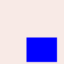

In [5]:
import PIL

im = PIL.Image.open(train_image_paths[0])
im

In [6]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer

from tokenizers.trainers import BpeTrainer

tokenizer = Tokenizer(BPE())

trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
tokenizer.train_from_iterator(train_questions, trainer=trainer)

dummy_text = "I love Pigeons"

IDS = tokenizer.encode(dummy_text)
print(IDS.ids)

[5, 73, 28, 15, 13, 11, 20, 19, 23]


In [7]:
import torch

batch_size = 32
emb = 384
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print(device)

cuda


In [8]:
from sentence_transformers import SentenceTransformer, util
st_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
output = st_model.encode(["Guten morgen"])
output.shape

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(1, 384)

In [9]:
from PIL.Image import Transform
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])
])

class EasyVQADataset(Dataset):
  def __init__(self, questions, answers, image_ids, image_paths):
    self.questions = questions
    self.answers = answers
    self.image_ids = image_ids
    self.image_paths = image_paths

  def __len__(self):
    return len(self.questions)

  def __getitem__(self, idx):
    question = self.questions[idx]
    answer = self.answers[idx]
    image_id = self.image_ids[idx]
    image_path = self.image_paths[image_id] # Corrected line in previous turn

    question_ids = st_model.encode([question])
    question_ids = torch.from_numpy(question_ids).to(device)
    answer_label = lookup_map[answer]

    img_loaded = PIL.Image.open(image_path)
    img = transform(img_loaded)

    return question_ids, img, torch.tensor(answer_label, dtype=torch.long), question # Changed dtype to torch.long


train_dataset = EasyVQADataset(train_questions[:100], train_answers[:100], train_image_ids[:100], train_image_paths)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = EasyVQADataset(test_questions, test_answers, test_image_ids, test_image_paths)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7bf529e18e30>,
 <torch.utils.data.dataloader.DataLoader at 0x7bf52981e0f0>)

In [10]:
#kurz model testen
import torch
import torchvision.models as models

model = models.vit_b_16(weights='IMAGENET1K_V1')
in_features = model.heads.head.in_features

In [11]:
print(f"Eingabefeatures des originalen FC-Layers: {in_features}")

Eingabefeatures des originalen FC-Layers: 768


In [12]:
from torch import nn

my_emb = 30
dummy = torch.randn(1, 3, 224, 224)
#model.heads.head = nn.Identity()
model.heads.head = nn.Linear(768, 30)
out = model(dummy)
out.shape

torch.Size([1, 30])

In [13]:
torch.cuda.empty_cache()
import gc
gc.collect()

219

In [23]:
import torch
torch.cuda.empty_cache()

class VQAModel(nn.Module):
  def __init__(self, vocab_size, embed, hidden, out, device):
    super().__init__()
    self.device = device
    self.text_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
    self.model = models.vit_b_16(weights='IMAGENET1K_V1')
    self.model.heads.head = torch.nn.Sequential(
        torch.nn.Linear(768, 512),
        torch.nn.Tanh(),
        torch.nn.Linear(512, 128),
        torch.nn.Tanh(),
        torch.nn.Linear(128, 32))

    self.fc1 = nn.Linear(embed, 64)
    self.fc2 = nn.Linear(64, 32)

    self.end = nn.Sequential(
        nn.Linear(64, hidden),
        nn.Tanh(),
        nn.Linear(hidden, out)
    )


  def forward(self, x_img, x_text):
    img_emb = self.model(x_img)
    #img_emb = img_emb.unsqueeze(dim=-1)
    #text_emb = self.text_model.encode([x_text]) #HIER NOCH IM DATASET DEN TEXT GEBEN
    #text_emb = torch.from_numpy(text_emb).to(self.device)
    text_emb = x_text.squeeze(dim=1)

    act = torch.nn.Tanh()
    text_emb = act(self.fc1(text_emb))
    text_emb = act(self.fc2(text_emb))

    #print(img_emb.shape)
    #print(text_emb.shape)
    combined_emb = torch.cat((img_emb, text_emb), 1)
    #print(combined_emb.shape)
    out = self.end(combined_emb)
    return out

vqaModel = VQAModel(tokenizer.get_vocab_size(), emb, 100, len(lookup_map), device).to(device)

In [33]:
#test gematsche
import torch.nn.functional as F

question, img, answer, q = next(iter(train_dataloader))
question, img, answer = question.to(device), img.to(device), answer.to(device)
print(question.dtype)


output = vqaModel(img, question)
output_logits = F.softmax(output, dim=-1)
out_label = torch.argmax(output_logits, dim=-1)
print(out_label[10])
print(answer[10])

torch.float32
tensor(6, device='cuda:0')
tensor(6, device='cuda:0')


In [16]:
question, img, answer = next(iter(train_dataloader))
answer.shape
answer = answer.long()              # sicherstellen, dass es LongTensor ist
one_hot = torch.nn.functional.one_hot(answer, num_classes=13)
print(one_hot.shape)

ValueError: too many values to unpack (expected 3)

In [24]:
optimizer = torch.optim.Adam(vqaModel.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [25]:
#training
import numpy as np

epochs = 1000

for epoch in range(epochs):
  loss_log = []
  for question, img, answer, q in train_dataloader:
    question, img, answer = question.to(device), img.to(device), answer.to(device)

    output = vqaModel(img, question)
    #output_logits = F.softmax(output, dim=-1)
    #out_label = torch.argmax(output_logits, dim=-1)
    #out_label[0]

    #answer = answer.long()
    #one_hot = torch.nn.functional.one_hot(answer, num_classes=13)

    loss = loss_fn(output, answer)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_log.append(loss.item())

  mean = np.mean(loss_log)
  print("In Epoch: " + str(epoch) + " gab es folgenden loss :) " + str(mean))

In Epoch: 0 gab es folgenden loss :) 2.3382675647735596
In Epoch: 1 gab es folgenden loss :) 1.8472523093223572
In Epoch: 2 gab es folgenden loss :) 1.6296387612819672
In Epoch: 3 gab es folgenden loss :) 1.7286508679389954
In Epoch: 4 gab es folgenden loss :) 1.5467033982276917
In Epoch: 5 gab es folgenden loss :) 1.5535591840744019
In Epoch: 6 gab es folgenden loss :) 1.656341403722763
In Epoch: 7 gab es folgenden loss :) 1.5083573311567307
In Epoch: 8 gab es folgenden loss :) 1.6704356968402863
In Epoch: 9 gab es folgenden loss :) 1.8783957064151764
In Epoch: 10 gab es folgenden loss :) 1.635818362236023
In Epoch: 11 gab es folgenden loss :) 1.6019884943962097
In Epoch: 12 gab es folgenden loss :) 1.7032153606414795
In Epoch: 13 gab es folgenden loss :) 1.4250071346759796
In Epoch: 14 gab es folgenden loss :) 1.4773817360401154
In Epoch: 15 gab es folgenden loss :) 1.5494388341903687
In Epoch: 16 gab es folgenden loss :) 1.286681741476059
In Epoch: 17 gab es folgenden loss :) 1.4061

In [26]:
torch.save(model.state_dict(),"modelWs.pth")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')